# Stochastic Simulations Assignment 3: Reverse Engineering Predator-Prey System

#### Job Marcelis, 14000946

#### Ernani Hazbolatow, 14272210

#### Haitham Muhidin, 13970356

Below are the required `Python` packages to run the code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import dual_annealing
import pandas as pd

from joblib import Parallel, delayed

plt.rcParams['figure.dpi'] = 300

To get a better understanding of the Lotka Volterra equations, we solve them using the following parameters: $\alpha = 3$, $\beta = 2$, $\delta = -1$, $\gamma = -2$. Furthermore, we use `solve_ivp` to solve the system of equations deterministically.

In [2]:
def LV_eqs(t, var, params):
    x, y = var
    a, b, c, d = params

    dxdt = a*x - b*x*y
    dydt = - c*y + d*x*y

    return [dxdt, dydt]

def solve_LV(start_time, stop_time, time_span, initial_conditions, params):
    result = solve_ivp(LV_eqs, [start_time, stop_time], initial_conditions, args=(params,), t_eval=time_span, method='RK45')
    X = result.y[0, :]
    Y = result.y[1, :]
    t = result.t

    return X, Y, t

In [67]:
init_cond = [4, 2]
params = [3, 2, 1, 2]
time_arr = np.linspace(0, 20, 1000)
X, Y, t = solve_LV(0, 20, time_arr, init_cond, params)

In addition to showing the time evolution of the deterministic model, we can also plot the phase space for multiple initial conditions. This reveals the periodic behaviour.

In [69]:
pred_pop = [1, 3, 5, 7]
phase_plot_X = np.zeros((len(pred_pop), 1000))
phase_plot_Y = np.zeros((len(pred_pop), 1000))

for i, pop in enumerate(pred_pop):
    X_phase, Y_phase, _ = solve_LV(10, 20, np.linspace(10, 20, 1000), [4, pop], params)
    phase_plot_X[i, :] = X_phase
    phase_plot_Y[i, :] = Y_phase

In [ ]:
colors = ['#87CEEB', '#ADD8E6', '#00BFFF', '#1E90FF']
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.title(fr'Deterministic Predator-Prey Model, $x_0 = {{{init_cond[0]}}}, y_0 = {{{init_cond[1]}}}$', fontsize=14)
plt.plot(t, X, color='blue', label='Prey')
plt.plot(t, Y, color='red', label='Predator')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title('Phase Space for Multiple Initial Conditions', fontsize=14)
for i in range(len(pred_pop)):
    plt.plot(phase_plot_X[i, :], phase_plot_Y[i, :], label=fr'$x_0 = {{{init_cond[0]}}}, y_0 = {{{pred_pop[i]}}}$')
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

Now, we plot the data that was given in `predator-prey-data.csv`.

In [5]:
data = pd.read_csv('predator-prey-data.csv')
t_data = data['t']
X_data = data['x']
Y_data = data['y']
X_data_var = np.var(X_data)
Y_data_var = np.var(Y_data)

In [ ]:
plt.figure(figsize=(9, 5))
plt.title('Predator-Prey Data', fontsize=14)
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend()
plt.show()

The goal is to find the best parameters to describe the data, which is done with two different optimizing algorithms, Hill climbing and Simulated Annealing. First, we define two objective functions, the sum of squared errors (SSE) and the mean squared error (MSE). Using these functions, we can calculate the difference between the siimulated results and the experimental results.

In [10]:
def SSE(data, model):
    return sum((data - model)**2)

def MSE(data, model):
    return np.mean((data - model)**2)

In [ ]:
def hill_climbing(init_guess, increment, iterations, obj_func):
    a, b, c, d = init_guess
    lowest_error = 1e5
    err_list = []
    x_errs = []  # will be iterations + 1 long due to also having to compute the initial guess
    y_errs = []  # same as x_errs

    abcd_incr_list = np.random.uniform(-increment, increment, (4, iterations))

    model_X, model_Y, model_t = solve_LV(0, 20, 100, [X_data[0], Y_data[0]], [a, b, c, d])
    x_err = obj_func(X_data, model_X)
    y_err = obj_func(Y_data, model_Y)
    x_errs.append(x_err)
    y_errs.append(y_err)
    for i in range(iterations):
        a = a + abcd_incr_list[0,i]
        b = b + abcd_incr_list[1,i]
        c = c + abcd_incr_list[2,i]
        d = d + abcd_incr_list[3,i]
        model_X, model_Y, model_t = solve_LV(0, 20, 100, [X_data[0], Y_data[0]], [a, b, c, d])
        x_err = obj_func(X_data, model_X)
        y_err = obj_func(Y_data, model_Y)
        x_errs.append(x_err)
        y_errs.append(y_err)
        if x_errs[-1] > x_errs[-2]:
            a = a - abcd_incr_list[0,i]
            b = b - abcd_incr_list[1,i]
        if y_errs[-1] > y_errs[-2]:
            c = c - abcd_incr_list[2,i]
            d = d - abcd_incr_list[3,i]
    return [[a,b,c,d], x_errs, y_errs]

In [ ]:
def calc_mean_conf_hill(results):
    means = np.mean(results, axis=0)
    conf = 1.96 * np.std(results, axis=0) / np.sqrt(len(results))

    return means, conf

In [10]:
def calc_mean_conf(results):
    means = np.mean(results, axis=0)
    conf = 1.96 * np.std(results, axis=0) / np.sqrt(len(results))
    return means, conf

In [ ]:
def simulation_wrapper(init_guess, increment, iterations, obj_func):
    return hill_climbing(init_guess, increment, iterations, obj_func)

def simulate_parallel(n_runs, init_guess, increment, iterations, obj_func):
    results = Parallel(n_jobs=-1)(delayed(simulation_wrapper)(init_guess, increment, iterations, obj_func) for _ in range(n_runs))
    abcds = np.array([results[j][0] for j in range(n_runs)])

    errors_x = np.array([results[k][1] for k in range(n_runs)])
    errors_y = np.array([results[g][2] for g in range(n_runs)])
    return [abcds, errors_x, errors_y]

In [ ]:
hill_clim_fit_SSE = simulate_parallel(100, [2, 1, 1, 1], 0.01, 1000, SSE)
hill_clim_fit_MSE = simulate_parallel(500, [2, 1, 1, 1], 0.01, 1000, MSE)

In [ ]:
means_SSE, conf_SSE = calc_mean_conf_hill(hill_clim_fit_SSE[0])
means_MSE, conf_MSE = calc_mean_conf_hill(hill_clim_fit_MSE[0])

In [ ]:
X_SSE_fit, Y_SSE_fit, t_SSE_fit = solve_LV(0, 20, 1000, [X_data[0], Y_data[0]], means_SSE)
X_MSE_fit, Y_MSE_fit, t_MSE_fit = solve_LV(0, 20, 1000, [X_data[0], Y_data[0]], means_MSE)

In [ ]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.title('Predator-Prey Data with Hill Climbing fit (SSE)', fontsize=14)
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator')
plt.plot(t_SSE_fit, X_SSE_fit, color='blue', label='Prey fit')
plt.plot(t_SSE_fit, Y_SSE_fit, color='red', label='Predator fit')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title('Predator-Prey Data with Hill Climbing fit (MSE)', fontsize=14)
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator')
plt.plot(t_MSE_fit, X_MSE_fit, color='blue', label='Prey fit')
plt.plot(t_MSE_fit, Y_MSE_fit, color='red', label='Predator fit')
plt.xlabel('Time', fontsize=14)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

#### Simulated Annealing

Below are again two different objective functions (SSE and MSE) to optimize the parameters using simulated annealing. We use `dual_annealing` from `scipy.optmize`. Since this library uses random sampling, we run multiple times and take the mean and confidence interval at the $p = 95\%$ confidence level.

In [ ]:
def annealing_SSE(params):
    a, b, c, d = params
    model_X, model_Y, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], [a, b, c, d])
    error_X = np.sum((X_data - model_X) ** 2) / X_data_var
    error_Y = np.sum((Y_data - model_Y) ** 2) / Y_data_var
    return error_X + error_Y

def annealing_MSE(params):
    a, b, c, d = params
    model_X, model_Y, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], [a, b, c, d])
    error_X = np.mean((X_data - model_X) ** 2) / X_data_var
    error_Y = np.mean((Y_data - model_Y) ** 2) / Y_data_var
    return error_X + error_Y

bounds = [(0.5, 2.5), (0.5, 2.5), (0.5, 2.5), (0.5, 2.5)]

def run_annealing(obj_func, seed):
    result = dual_annealing(obj_func, bounds, seed=seed)
    return result.x

In [ ]:
annealing_MSE_results = Parallel(n_jobs=-1)(delayed(run_annealing)(annealing_MSE, seed) for seed in range(50))
annealing_SSE_results = Parallel(n_jobs=-1)(delayed(run_annealing)(annealing_SSE, seed) for seed in range(50))

In [39]:
annealing_MSE_results = np.array(annealing_MSE_results)
annealing_SSE_results = np.array(annealing_SSE_results)

means_MSE, conf_MSE = calc_mean_conf(annealing_MSE_results)
means_SSE, conf_SSE = calc_mean_conf(annealing_SSE_results)

In [ ]:
for i in range(4):
    print(f'Param: {means_MSE[i]} +- {conf_MSE[i]}')

In [73]:
anneal_fit_MSE_X, anneal_fit_MSE_Y, anneal_fit_t = solve_LV(0, 20, time_arr, [X_data[0], Y_data[0]], means_MSE)
anneal_fit_SSE_X, anneal_fit_SSE_Y, anneal_fit_t = solve_LV(0, 20, time_arr, [X_data[0], Y_data[0]], means_SSE)

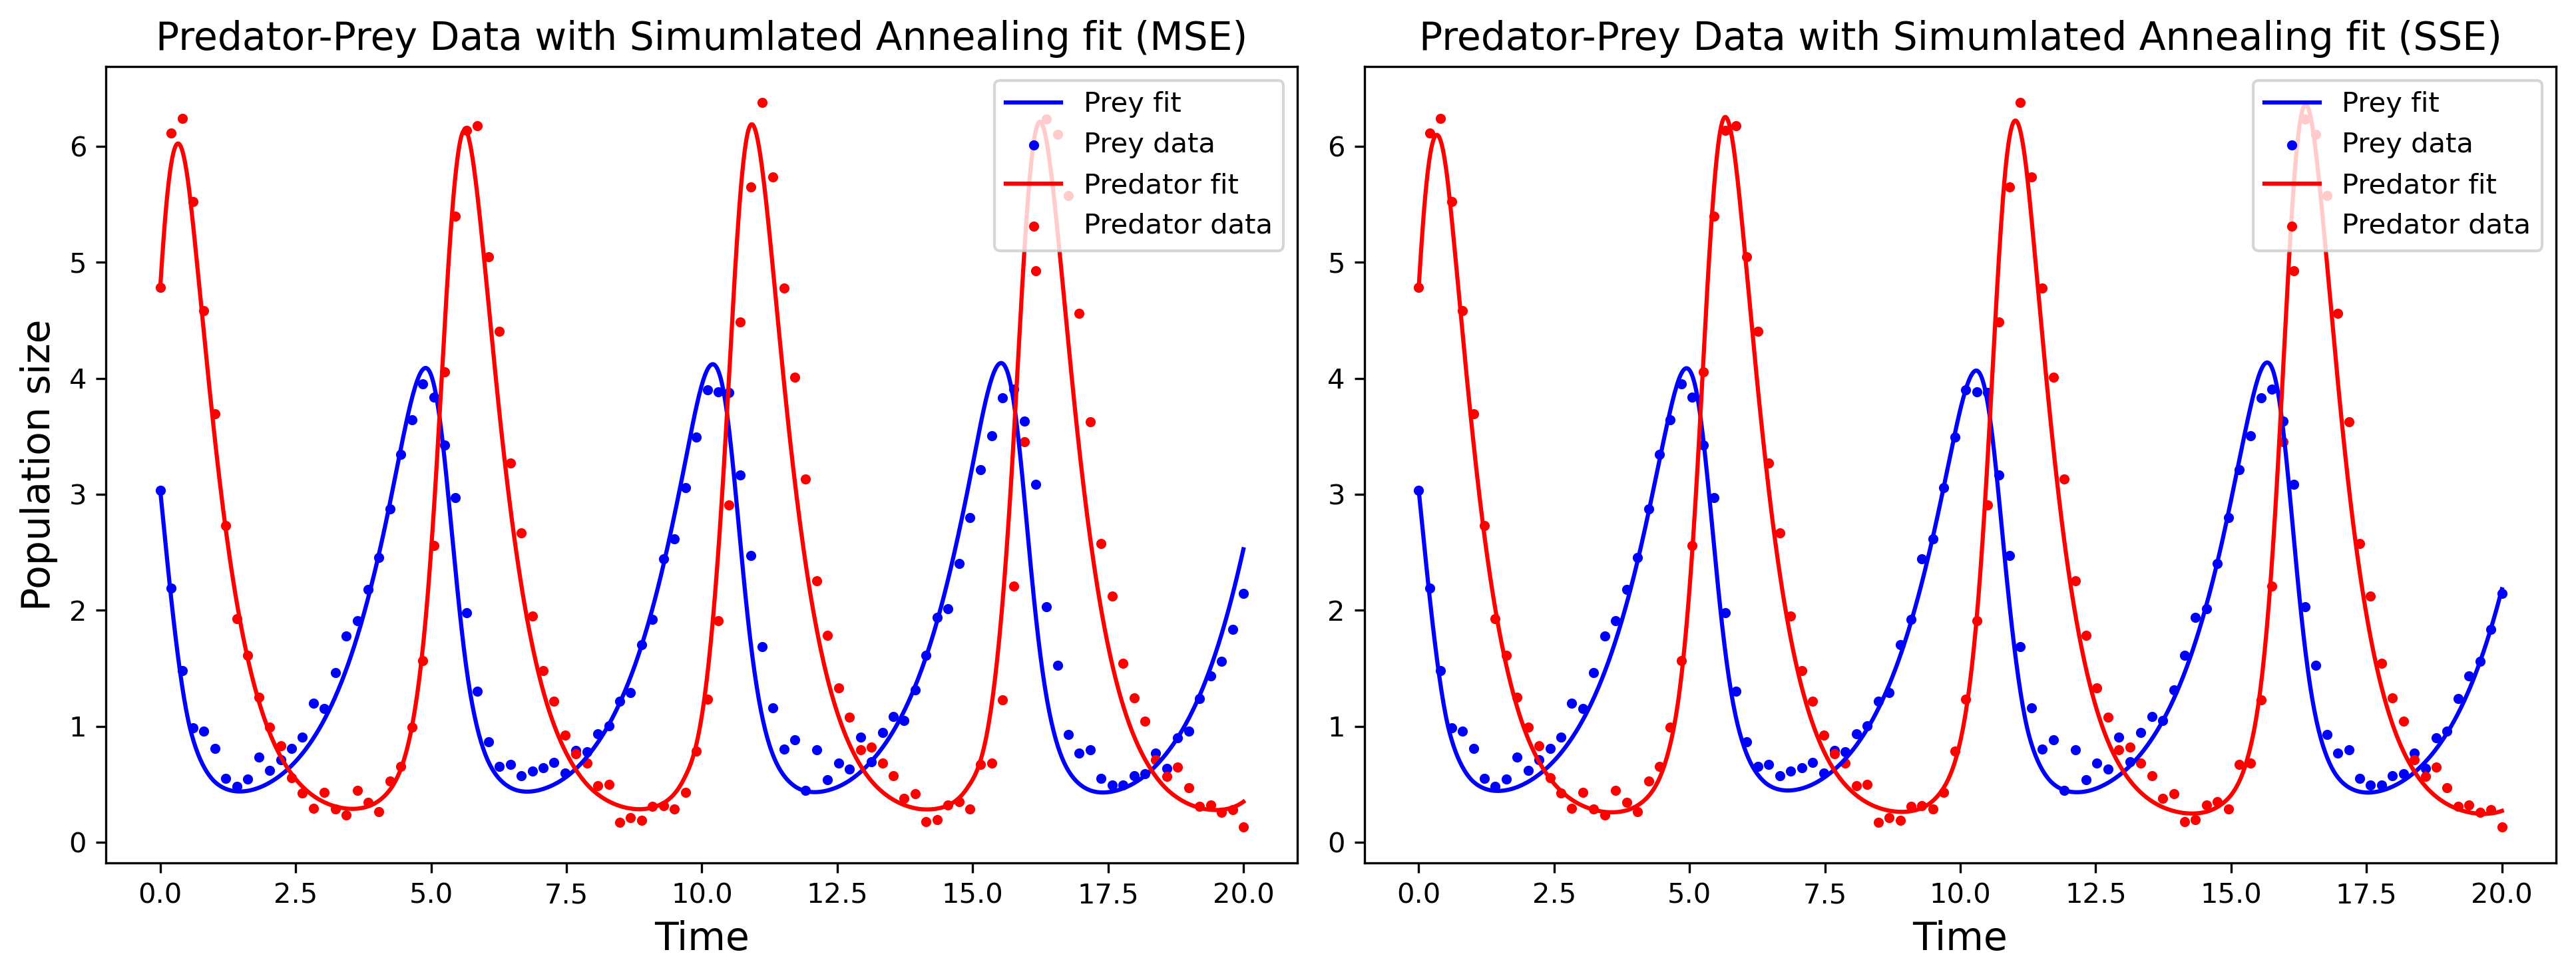

In [74]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.title('Predator-Prey Data with Simumlated Annealing fit (MSE)', fontsize=14)
plt.plot(anneal_fit_t, anneal_fit_MSE_X, color='blue', label='Prey fit')
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey data')
plt.plot(anneal_fit_t, anneal_fit_MSE_Y, color='red', label='Predator fit')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator data')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title('Predator-Prey Data with Simumlated Annealing fit (SSE)', fontsize=14)
plt.plot(anneal_fit_t, anneal_fit_SSE_X, color='blue', label='Prey fit')
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey data')
plt.plot(anneal_fit_t, anneal_fit_SSE_Y, color='red', label='Predator fit')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator data')
plt.xlabel('Time', fontsize=14)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

To determine how good the fit is, we calculate the reduced $\chi^2$. Since the data points do not have errors, we estimate the error with the standard deviation from the residuals. Furthermore, since we have to curves to fit, the total $\chi^2$ is the sum of both fitted curves. The degrees of freedom is $\nu = N - p = 200 - 4$.

In [6]:
def reduced_chi2(model_prey, model_predator):
    std_prey = np.std(X_data - model_prey)
    std_predator = np.std(Y_data - model_predator)
    chi2 = sum((X_data - model_prey)**2 / std_prey**2) + sum((Y_data - model_predator)**2 / std_predator**2)
    red_chi2 = chi2 / (2*len(X_data) - 4)
    return red_chi2

In [ ]:
chi2_MSE_X, chi2_MSE_Y, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], means_MSE)
chi2_SSE_X, chi2_SSE_Y, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], means_SSE)
chi2_MSE = reduced_chi2(chi2_MSE_X, chi2_MSE_Y)
chi2_SSE = reduced_chi2(chi2_SSE_X, chi2_SSE_Y)
print(f'Reduced chi2 using MSE: {chi2_MSE}')
print(f'Reduced chi2 using SSE: {chi2_SSE}')

We determine how many data points we can delete while still getting a good fit. First, we fix the $x$ data and randomly delete points from the $y$ data, we then calculate the parameters with less data and if the resulting parameters fall within the confidence interval of the original parameters, we conclude that we can still reverse engineer the dynamics. For this part we use simulated annealing with the MSE as objective function, since that gave the best fit. 

In [8]:
annealing_MSE_baseline = Parallel(n_jobs=-1)(delayed(run_annealing)(annealing_MSE, seed) for seed in range(25))

In [11]:
annealing_MSE_baseline = np.array(annealing_MSE_baseline)
mean_baseline, conf_baseline = calc_mean_conf(annealing_MSE_baseline)

for i in range(4):
    print(f'Param: {mean_baseline[i]} +- {conf_baseline[i]}')

Param: 0.9723904343821839 +- 0.043679213668444634
Param: 0.5090798274382995 +- 0.009158644004930029
Param: 1.8427970002135465 +- 0.10334258020961846
Param: 1.093122069811176 +- 0.06301850061988742


In [13]:
X_data_copy = X_data.copy()
Y_data_copy = Y_data.copy()
t_data_copy = t_data.copy()

In [14]:
def annealing_deletion_Y(params):
    a, b, c, d = params
    X_model, _, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], [a, b, c, d])
    _, Y_model, _ = solve_LV(0, 20, t_data_copy, [X_data[0], Y_data[0]], [a, b, c, d])
    error_X = np.mean((X_data_copy - X_model) ** 2)
    error_Y = np.mean((Y_data_copy - Y_model) ** 2)
    return error_X + error_Y

In [ ]:
num_deletions = [1, 5, 10, 15]
mean_params = np.zeros((len(num_deletions), 4))
conf_params = np.zeros((len(num_deletions), 4))

for i, deletions in enumerate(num_deletions):
    # Delete random data points
    np.random.seed(i)
    deletion_idx = np.random.choice(range(1, len(Y_data_copy)), size=deletions, replace=False)
    Y_data_copy = np.delete(Y_data_copy, deletion_idx)
    t_data_copy = np.delete(t_data_copy, deletion_idx)

    # Calculate params
    deletion_Y_params = Parallel(n_jobs=-1)(delayed(run_annealing)(annealing_deletion_Y, seed) for seed in range(25))
    deletion_Y_params = np.array(deletion_Y_params)
    means, confs = calc_mean_conf(deletion_Y_params)
    mean_params[i, :] = means
    conf_params[i, :] = confs

    # Reset data
    Y_data_copy = Y_data.copy()
    t_data_copy = t_data.copy()

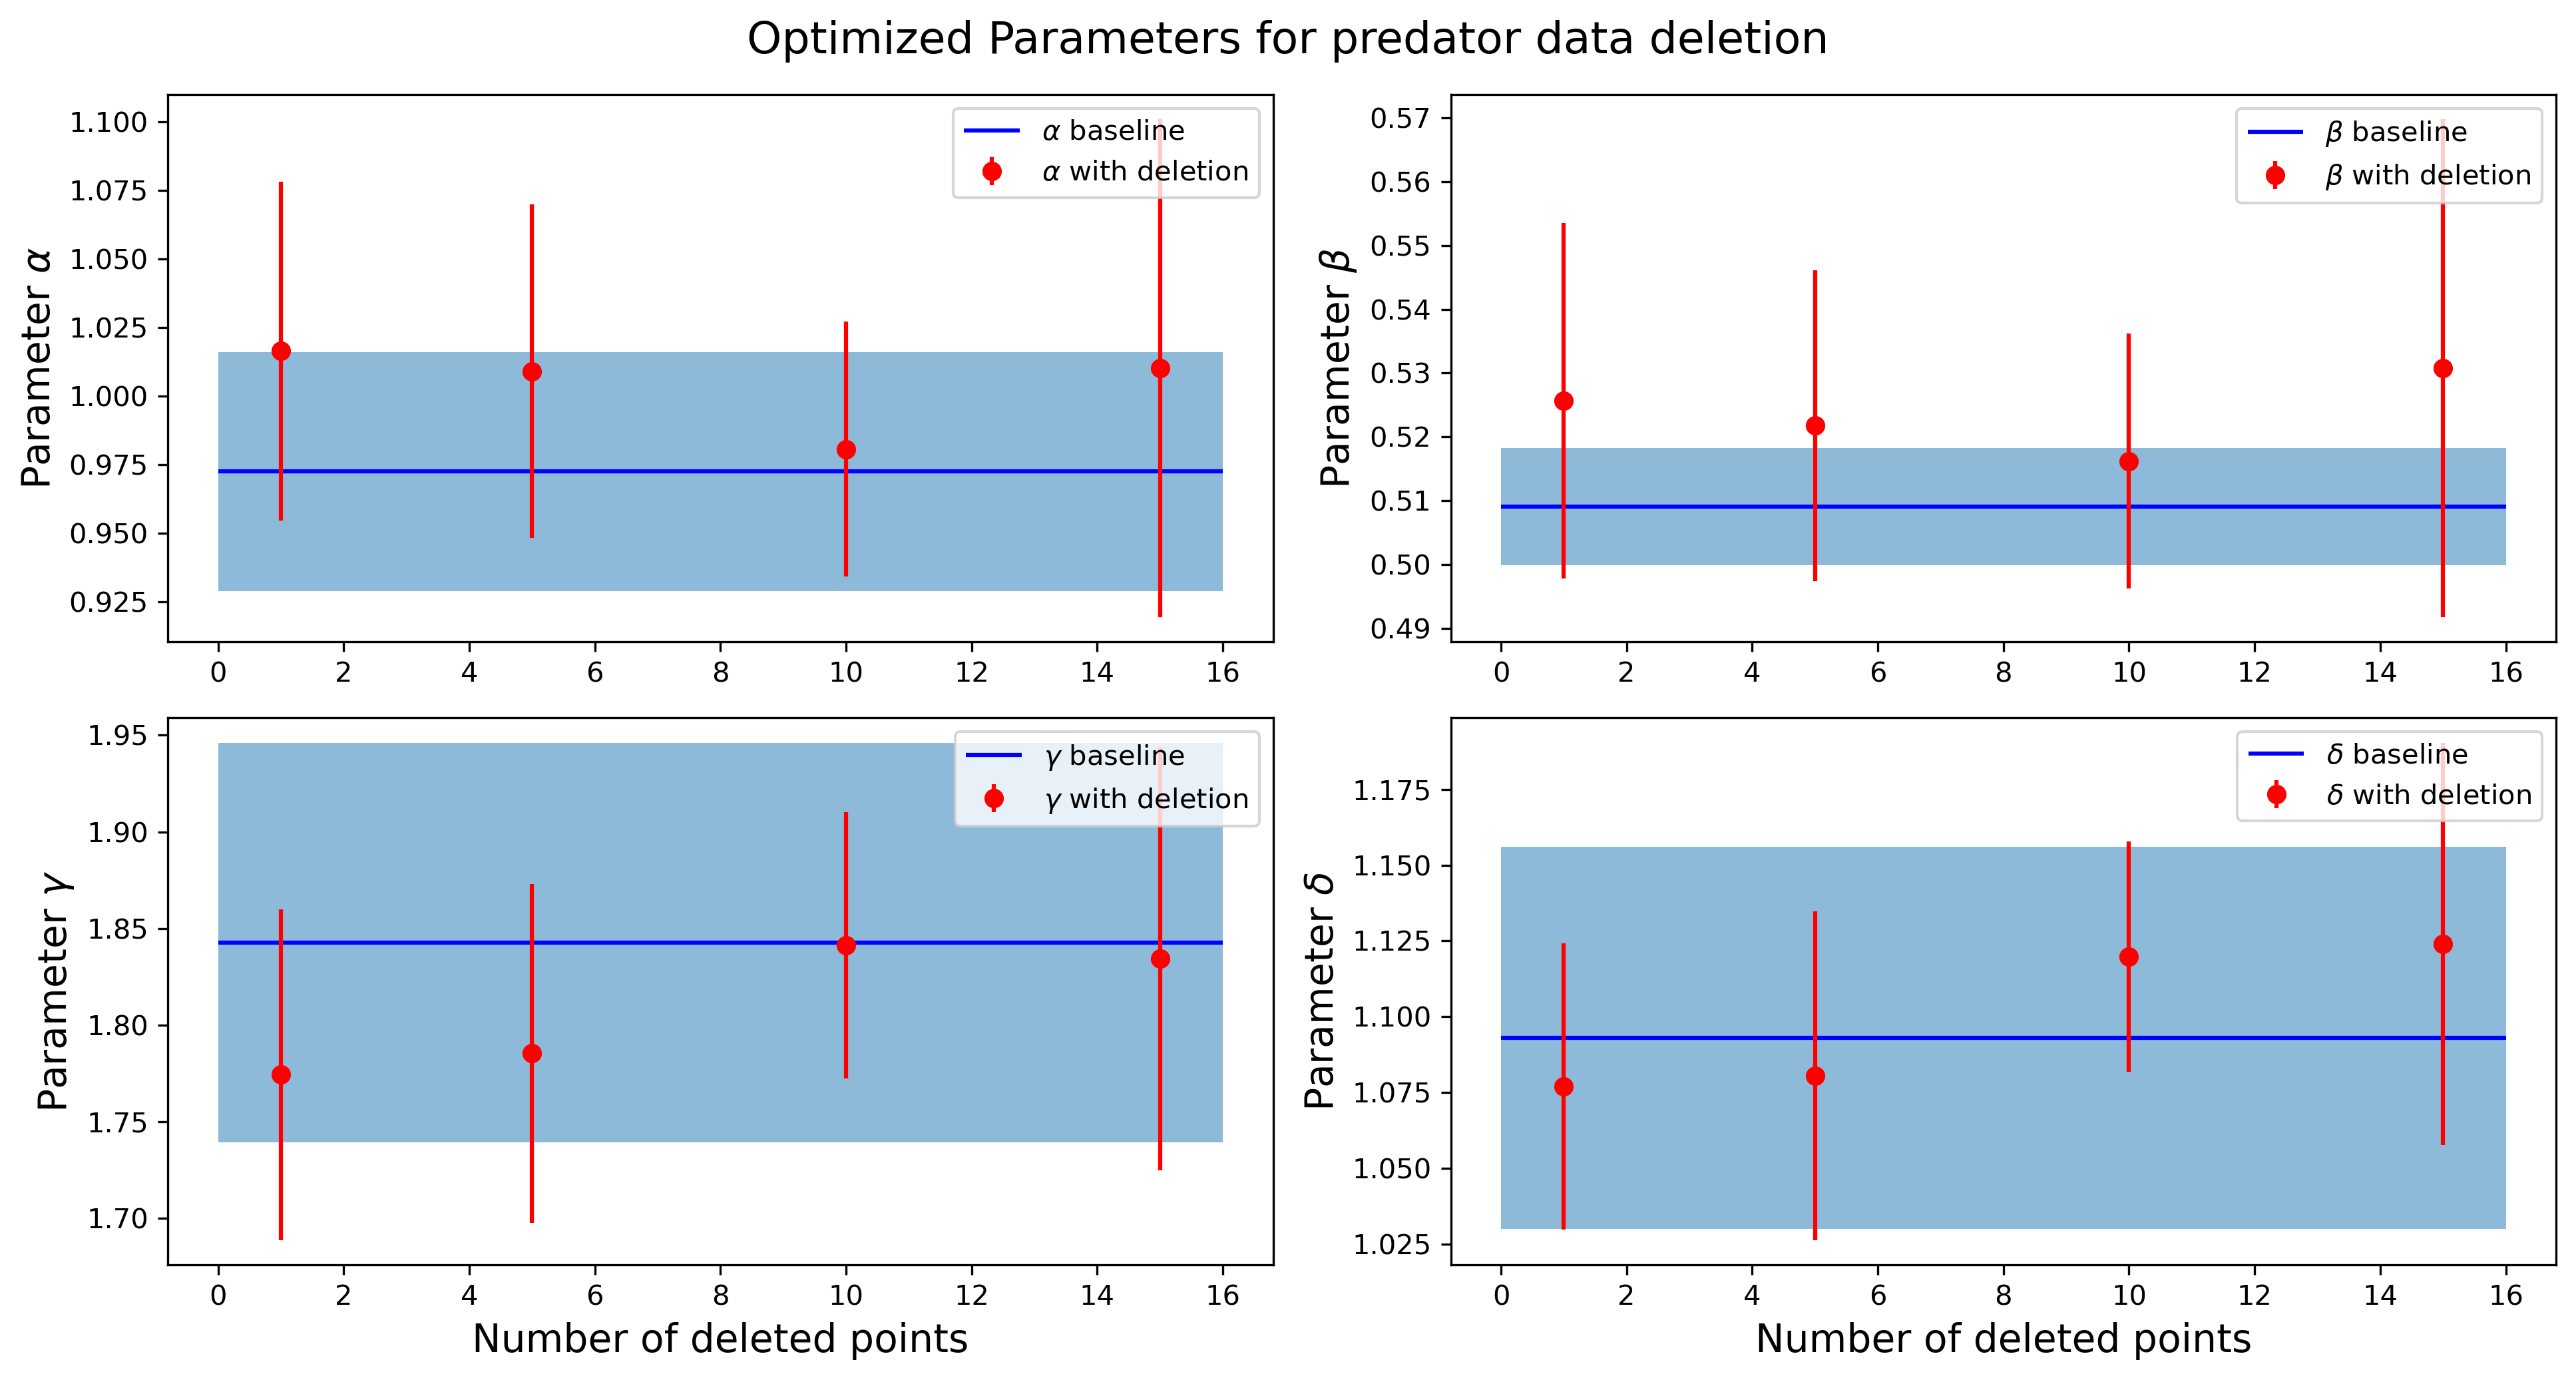

In [18]:
x_range = range(0, num_deletions[-1] + 2)

plt.figure(figsize=(13, 7))
plt.suptitle('Optimized Parameters for predator data deletion', fontsize=16)

plt.subplot(2, 2, 1)
plt.hlines(mean_baseline[0], xmin=0, xmax=num_deletions[-1] + 1, color='blue', label=r'$\alpha$ baseline')
plt.fill_between(x_range, mean_baseline[0] - conf_baseline[0], mean_baseline[0] + conf_baseline[0], alpha=0.5)
plt.errorbar(num_deletions, mean_params[:, 0], yerr=conf_params[:, 0], fmt='o', color='red', label=r'$\alpha$ with deletion')
plt.ylabel(r'Parameter $\alpha$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 2)
plt.hlines(mean_baseline[1], xmin=0, xmax=num_deletions[-1] + 1, color='blue', label=r'$\beta$ baseline')
plt.fill_between(x_range, mean_baseline[1] - conf_baseline[1], mean_baseline[1] + conf_baseline[1], alpha=0.5)
plt.errorbar(num_deletions, mean_params[:, 1], yerr=conf_params[:, 1], fmt='o', color='red', label=r'$\beta$ with deletion')
plt.ylabel(r'Parameter $\beta$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 3)
plt.hlines(mean_baseline[2], xmin=0, xmax=num_deletions[-1] + 1, color='blue', label=r'$\gamma$ baseline')
plt.fill_between(x_range, mean_baseline[2] - conf_baseline[2], mean_baseline[2] + conf_baseline[2], alpha=0.5)
plt.errorbar(num_deletions, mean_params[:, 2], yerr=conf_params[:, 2], fmt='o', color='red', label=r'$\gamma$ with deletion')
plt.xlabel('Number of deleted points', fontsize=14)
plt.ylabel(r'Parameter $\gamma$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 4)
plt.hlines(mean_baseline[3], xmin=0, xmax=num_deletions[-1] + 1, color='blue', label=r'$\delta$ baseline')
plt.fill_between(x_range, mean_baseline[3] - conf_baseline[3], mean_baseline[3] + conf_baseline[3], alpha=0.5)
plt.errorbar(num_deletions, mean_params[:, 3], yerr=conf_params[:, 3], fmt='o', color='red', label=r'$\delta$ with deletion')
plt.xlabel('Number of deleted points', fontsize=14)
plt.ylabel(r'Parameter $\delta$', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()